In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import umap
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

X_train = np.load('/kaggle/input/intent-detection/X_train.npy')
X_test = np.load('/kaggle/input/intent-detection/X_test.npy')
Y_train = pd.read_csv('/kaggle/input/intent-detection/y_train.csv').Predicted.to_numpy()

# EDA

In [2]:
X_train.shape

(1663, 768)

In [3]:
Y_train.shape

(1663,)

In [4]:
X_test.shape

(713, 768)

**768 features; 1663 labels; 713 test data points**

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
feat_col = [f'feat{i}' for i in range(X_test.shape[1])]
X_train_df = pd.DataFrame(X_train, columns = feat_col)
Y_train_df = pd.DataFrame(Y_train,columns = ["Target"])
XY_train_df = pd.concat([X_train_df, Y_train_df],axis = 1)
X_test_df = pd.DataFrame(X_test, columns=feat_col)

In [7]:
XY_train_df.info()
#Training dataset are all floats, Target variable are ints

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Columns: 769 entries, feat0 to Target
dtypes: float32(768), int64(1)
memory usage: 4.9 MB


In [8]:
XY_train_df.isnull().sum().sum()
#0 null values in all of training dataset

0

In [9]:
XY_train_df.duplicated().sum()
#31 duplicated rows in training dataset

31

In [10]:
XY_train_df.drop_duplicates(inplace=True)
#removed duplicates in training dataset

In [11]:
XY_train_df[feat_col].duplicated().sum()
#there is a duplicate that differs only in the target column

1

In [12]:
#Identifying duplicate rows with difference in target column
XY_train_df[XY_train_df[feat_col].duplicated(keep=False)]

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat759,feat760,feat761,feat762,feat763,feat764,feat765,feat766,feat767,Target
46,2.252582,-1.56987,-0.288167,0.364211,-0.145699,0.303952,1.038688,-0.675855,1.073988,0.828697,...,2.908514,1.988179,-0.480898,1.80298,2.525123,0.669782,0.755354,0.012853,-0.246072,9
1478,2.252582,-1.56987,-0.288167,0.364211,-0.145699,0.303952,1.038688,-0.675855,1.073988,0.828697,...,2.908514,1.988179,-0.480898,1.80298,2.525123,0.669782,0.755354,0.012853,-0.246072,13


In [13]:
#Removing both rows 46 and 1478 since I don't know which is correct
XY_train_df.drop(axis=0,labels=[46,1478],inplace=True)


In [14]:
XY_train_df.reset_index(inplace=True,drop=True)

In [15]:
reducer = umap.UMAP(n_neighbors=10,min_dist=0.05)

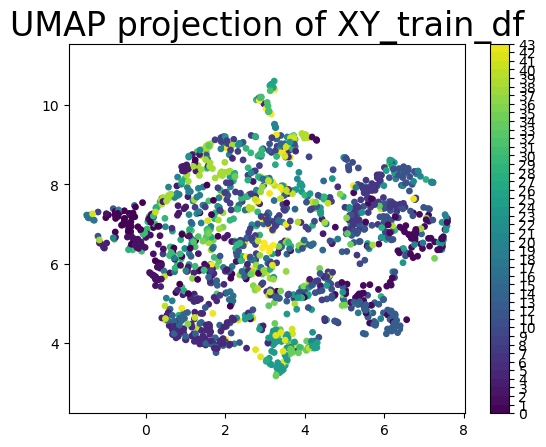

In [16]:
embedding = reducer.fit_transform(XY_train_df.iloc[:,:-1])

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c= XY_train_df.iloc[:,-1],
    s= 15
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of XY_train_df', fontsize=24);
plt.colorbar(boundaries=np.arange(44)).set_ticks(np.arange(44))

Clusters cleary visible

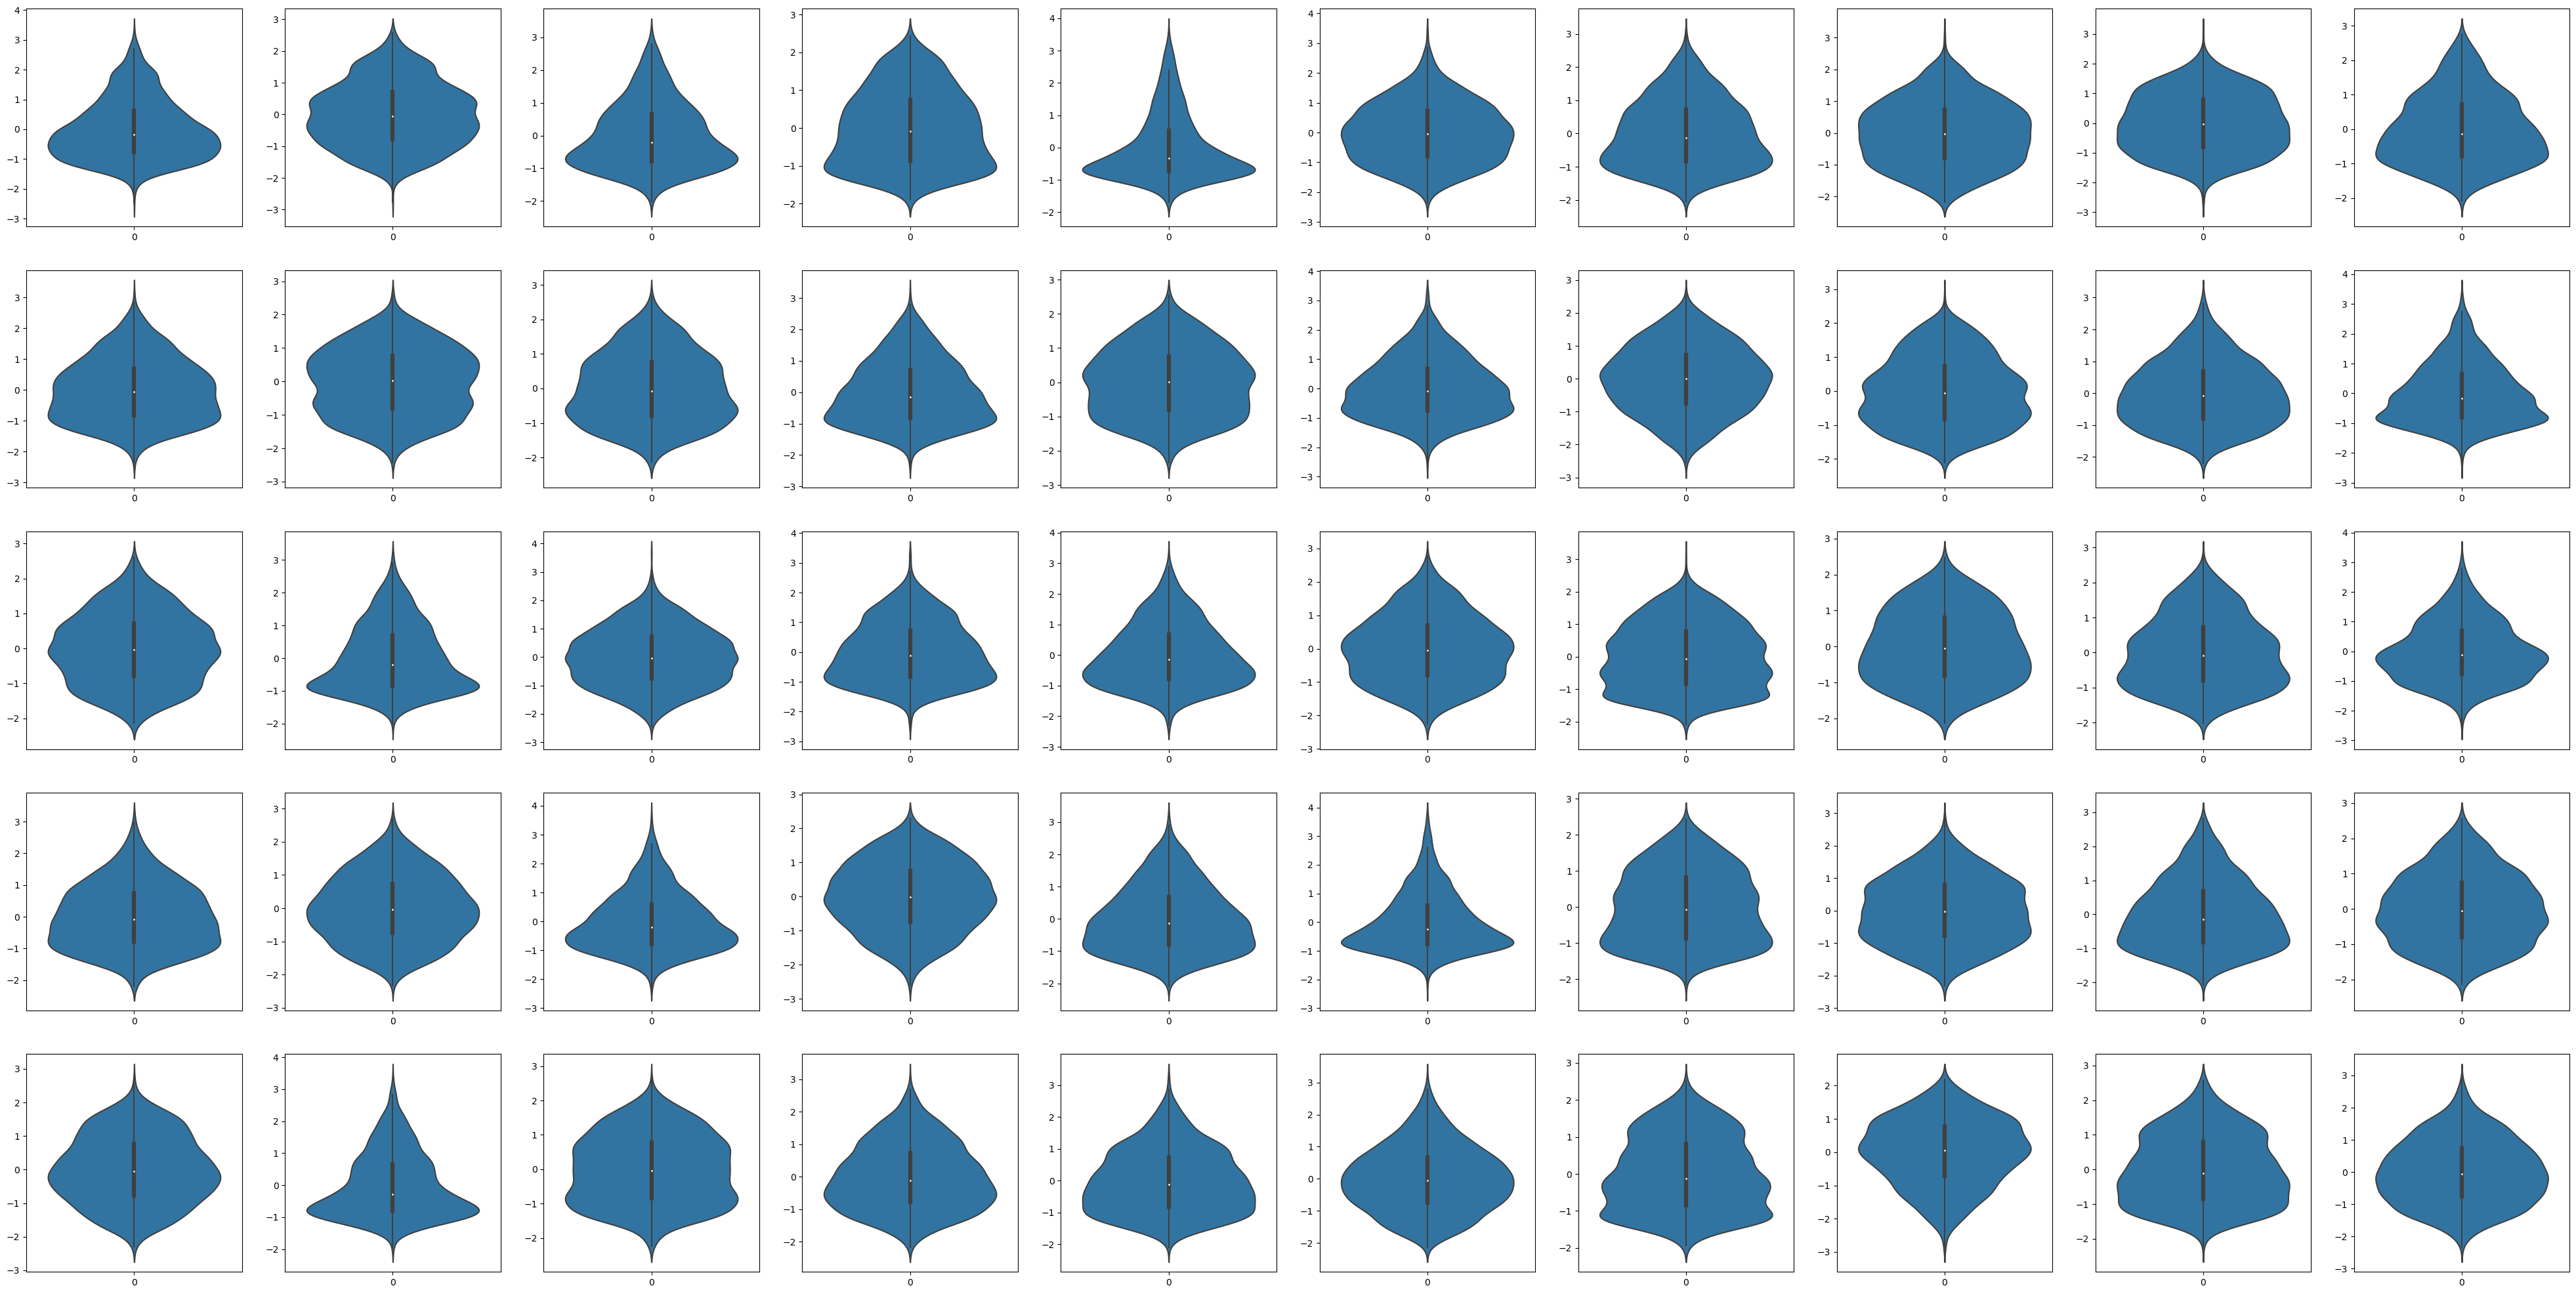

In [17]:
plot_col = feat_col[:50]
ncols = 10
nrows = len(plot_col) // ncols
plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i, col in enumerate(plot_col):
    plt.subplot(nrows, ncols, i+1)
    sns.violinplot(data=XY_train_df[col])
    
#Data seems farily symmetrical, but let's check for the skewness

In [18]:
XY_train_df.skew().sort_values()
#No need to correct for Skewness

feat216   -1.060204
feat320   -0.321927
feat406   -0.273430
feat47    -0.235508
feat272   -0.231030
             ...   
feat275    1.104433
feat748    1.124569
feat4      1.130471
feat532    1.147938
feat179    1.297135
Length: 769, dtype: float64

In [19]:
#training dataframes with cleaned data
X_train_df = XY_train_df.drop('Target', axis=1)
Y_train_df = XY_train_df['Target']

# Models

In [20]:
#Splitting the data using Stratified K-fold

skf = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, test_index in skf.split(X_train_df, Y_train_df):
    X_train, X_test = X_train_df.iloc[train_index], X_train_df.iloc[test_index]
    y_train, y_test = Y_train_df.iloc[train_index], Y_train_df.iloc[test_index]

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 2000,penalty='l2',C=500)
scores = []

In [22]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

score = f1_score(y_test, y_pred, average='micro')
scores.append(score)
    
mean_score = np.mean(scores)

print(f'Mean f1 score: {mean_score:.3f}')
#f1-micro score - 0.617

Mean f1 score: 0.617


## MLP Classifier

In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500,),random_state= 42,solver='lbfgs', alpha=1e-3)
scores = []

In [24]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

score = f1_score(y_test, y_pred, average='micro')
scores.append(score)

mean_score = np.mean(scores)

print(f'Mean f1-micro score: {mean_score:.3f}')

#f1-micro score - 0.626

Mean f1-micro score: 0.626


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500)
scores = []

In [26]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

score = f1_score(y_test, y_pred, average='micro')
scores.append(score)

mean_score = np.mean(scores)

print(f'Mean f1-micro score: {mean_score:.3f}')

#f1-micro score: 0.518

Mean f1-micro score: 0.518


# Save Output

***Best Model -> MLP Classifier***

In [27]:
# Predictions on test set
y_pred_final = mlp.predict(X_test_df)

In [28]:
y_pred_final_df = pd.DataFrame(y_pred_final)

In [29]:
y_pred_final_df.to_csv("results.csv", header = ['Predicted'],index_label = 'id')